# Data Cleaning on *Neutral-es* dataset

In this notebook we clean the dataset of [_Neutral-es_](https://huggingface.co/datasets/hackathon-pln-es/neutral-es). We will tackle hard difficulties in text data cleaning such as sentences with grammatical mistakes identification, sentences with similar structures detection, repetitive substrings cleaning and spelling mistakes corrections among others.

&emsp;&emsp;[1. Exploratory Data Analysis](#1.-Exploratory-Data-Analysis)<br>
&emsp;&emsp;&emsp;[1.1. General information and visual exploration](#1.1.-General-information-and-visual-exploration)<br>
&emsp;&emsp;&emsp;[1.2 Texts length distribution](#1.2-Texts-length-distribution)<br>
&emsp;&emsp;&emsp;[1.3. Invariant texts](#1.3.-Invariant-texts)<br>
&emsp;&emsp;&emsp;[1.4. Cleaning issues summary](#1.4.-Cleaning-issues-summary)<br>
&emsp;&emsp;[2. Fixing Issues](#2.-Fixing-Issues)<br>
&emsp;&emsp;&emsp;[2.1. Repetitive substrings](#2.1.-Repetitive-substrings)<br>
&emsp;&emsp;&emsp;&emsp;&emsp;[Mistakes in rows 899, 974, 1024 and 1540](#Mistakes-in-rows-899%2C-974%2C-1024-and-1540)<br>
&emsp;&emsp;&emsp;[2.2. Spelling and orthography correction with excel](#2.2.-Spelling-and-orthography-correction-with-excel)<br>
&emsp;&emsp;&emsp;[2.3. Grammar mistakes detection with HuggingChat](#2.3.-Grammar-mistakes-detection-with-HuggingChat)<br>
&emsp;&emsp;&emsp;[2.4. Repeated text structures detection with Sacrebleu metric](#2.4.-Repeated-text-structures-detection-with-Sacrebleu-metric)<br>
&emsp;&emsp;&emsp;[2.5. Text length anomalous distribution](#2.5.-Text-length-anomalous-distribution)<br>
&emsp;&emsp;&emsp;[2.6. High number of invariant texts](#2.6.-High-number-of-invariant-texts)<br>
&emsp;&emsp;[3. Save clean data](#3.-Save-clean-data)<br>

In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_colwidth = 200

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

c:\Users\andre\anaconda3\envs\linclusivo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Exploratory Data Analysis

### 1.1. General information and visual exploration
We load the dataset, we get general information and we perform a quick visual exploration

In [2]:
# Load dataset
dataset = load_dataset("hackathon-pln-es/neutral-es")
df_train = dataset['train'].to_pandas()
df_test = dataset['test'].to_pandas()

# datasets shapes
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)

# Concatenate train and test set in a single dataframe
df = pd.concat([df_train, df_test], ignore_index=True)
print('Total data shape:', df.shape, '\n')

# print dataset info
print('\n', df.info())
df.head(15)


Train shape: (3513, 2)
Test shape: (96, 2)
Total data shape: (3609, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3609 entries, 0 to 3608
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gendered  3609 non-null   object
 1   neutral   3609 non-null   object
dtypes: object(2)
memory usage: 56.5+ KB

 None


,gendered,neutral
0,Se han incorporado al centro dos docentes para el nuevo curso. Los formadores Rubén y Juan serán los responsables de coordinar el departamento de Conocimiento del Medio.,Se han incorporado al centro dos docentes para el nuevo curso. Los profesores Rubén y Juan serán los responsables de coordinar el departamento de Conocimiento del Medio.
1,Tenemos que cubrir las carencias que presenta el el promotor incorporando personal con un perfil diferente con un perfil diferente para compensar los erroes pasados,Tenemos que cubrir las carencias que presenta el el equipo promotor incorporando personal con un perfil diferente con un perfil diferente para compensar los erroes pasados
2,Habla con tu médico para averiguar si necesitas que se cambie tu dosis de paracetamol o del resto medicamentos que consumes de manera habitual,Habla con tu médico para averiguar si necesitas que se cambie tu dosis de paracetamol o del resto medicamentos que consumes de manera habitual
3,"Mientras tanto , el espectador comenzaba a impacientarse","Mientras tanto , la audiencia comenzaba a impacientarse"
4,Los intermediarios del acuerdo se ocuparán también de saber si la clínica tiene todas sus cuentas al día y si no hay problemas legales pendientes,El equipo intermediadior del acuerdo se ocupará también de saber si la clínica tiene todas sus cuentas al día y si no hay problemas legales pendientes
5,Se entrevistará a los tutores por orden de entrega.,Se entrevistará al profesorado por orden de entrega.
6,El tiempo que esté aquí no debe tomar ninguna medicación que no le sea suministrada por los especialistas en su cirujía,El tiempo que esté aquí no debe tomar ninguna medicación que no le sea suministrada por el personal experto en su cirujía
7,Es importante solventar los problemas que tiene el el promotor añadiendo personal con un perfil diferente con un perfil diferente para compensar los erroes pasados,Es importante solventar los problemas que tiene el el personal promotor añadiendo personal con un perfil diferente con un perfil diferente para compensar los erroes pasados
8,"Estas iniciativas se desarrollan en todo el espectro de interacciones entre los funcionarios y el público , ya sea en el gobierno , salud entre otros","Estas iniciativas se desarrollan en todo el espectro de interacciones entre el funcionariado y el público , ya sea en el gobierno , salud entre otros"
9,Mientras esté ingresado no debe tomar ninguna medicación que no le sea suministrada por los especializados en este caso,Mientras esté ingresado no debe tomar ninguna medicación que no le sea suministrada por el personal experto en este caso


We have a datasset with 3609 rows and no missing values. It has two columns the first one containing a gendered sentence and the second with a neutral version of the same sentence.

We also observe some text corrections issues on the firsts rows:
- **Repeated substrings** (row 1: _"Tenemos que cubrir las carencias que presenta el el promotor incorporando personal <u>con un perfil diferente con un perfil diferente</u> para compensar los erroes pasados"_)

- **Spelling mistakes** (row 1: _"...para compensar los <u>erroes</u> pasados"_; row 6: _"...especialistas en su <u>cirujía</u>"_)

- **Grammar mistakes** (row 13: _"Estos servicios permitirán que <u>los administrativos trabaje</u> con más eficacia y <u>realice</u> sus actividades de manera más óptima"_)

- **Repeated text structures** (rows 1, 7, 14... rows 6, 9, 10, 11...)

We search for duplicates and drop them.

In [3]:
# Count duplicates
mask = df.duplicated()
print('Number of duplicates:', df[mask].shape[0])
print(f'Percentaje of duplicates: {100*df[mask].shape[0]/df.shape[0]:.2f}% of total')

# Drop duplicates
df = df.drop_duplicates(ignore_index=True)
print('\nTotal data shape (after removing duplicates):', df.shape)

Number of duplicates: 133
Percentaje of duplicates: 3.69% of total

Total data shape (after removing duplicates): (3476, 2)


### 1.2 Texts length distribution

We analyse the length distribution of the sentences in number of words. 

 Inputs length (number of words) 
count    3476.000000
mean       16.098101
std         6.718546
min         2.000000
25%        10.000000
50%        16.000000
75%        22.000000
max        53.000000
Name: gendered, dtype: float64 

 Target length (number of words) 
count    3476.000000
mean       16.272727
std         7.017705
min         2.000000
25%        10.000000
50%        16.000000
75%        22.000000
max        53.000000
Name: neutral, dtype: float64


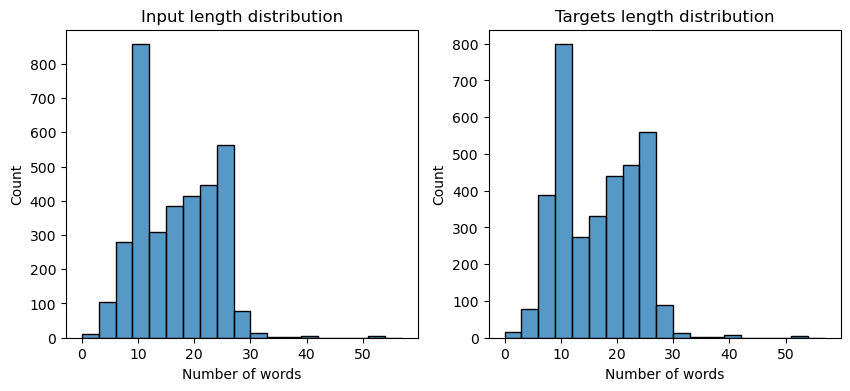

In [4]:
# Word count function
def word_count(string):
  return len(string.split())

# Count words
inputs_length = df['gendered'].map(word_count)
targets_length = df['neutral'].map(word_count)

# Statistics
print('\033[1m Inputs length (number of words) \033[0m')
print(inputs_length.describe(), '\n')

print('\033[1m Target length (number of words) \033[0m')
print(targets_length.describe())

# Plot length distribution
fig, axes = plt.subplots(1,2, figsize=[10,4])

bins = np.arange(0, 60, 3)

sns.histplot(inputs_length, ax=axes[0], bins=bins)
axes[0].set_title('Input length distribution')
axes[0].set_xlabel('Number of words')

sns.histplot(targets_length, ax=axes[1], bins=bins)
axes[1].set_title('Targets length distribution')
axes[1].set_xlabel('Number of words');


Sentences have 16 words in average, and target sentences (neutral version of input sentences) are longer in average. 

Length distribution shows some sharp peaks and it is quite **far from a normal distribution**. A normal distribution is expected in random samples. We know that there are repeated structures on this dataset and probably these repeated structures are the reason behind these sharp peaks and the not normal distribution.

### 1.3. Invariant texts

It is spected to have samples of data where sentences do not need to be modified (because they are already neutral or do not imply neutralization issues). We analyse data where input and target (gendered and neutral) are equal.

In [5]:
# find and count invariant texts
mask = df['gendered'] == df['neutral']
n_equals = mask.sum()

# Print results
print('\033[1m Input = Target \033[0m')
print('Total number:', n_equals, 'examples')
print(f'Percentage: {100*n_equals/df.shape[0]:.1f}% of total\n')

 Input = Target 
Total number: 1009 examples
Percentage: 29.0% of total



29% of dataset are data where input is equal to target. It is quite a big amount.

## 1.4. Cleaning issues summary

So far we have found the following issues to fix on this dataset:

- **Repeated substrings** (row 1: _"Tenemos que cubrir las carencias que presenta el el promotor incorporando personal <u>con un perfil diferente con un perfil diferente</u> para compensar los erroes pasados"_)

- **Spelling mistakes** (row 1: _"...para compensar los <u>erroes</u> pasados"_; row 6: _"...especialistas en su <u>cirujía</u>"_)

- **Grammar mistakes** (row 13: _"Estos servicios permitirán que <u>los administrativos trabaje</u> con más eficacia y <u>realice</u> sus actividades de manera más óptima"_)

- **Repeated text structures** (rows 1, 7, 14... rows 6, 9, 10, 11...)

- **Strange length distribution**: non normal distribution with sharp high peaks

- **Big amount of invariant texts**: 29% of the dataset

## 2. Fixing Issues

### 2.1. Repetitive substrings

We detected that there are repeated contiguous subsequences. It would be interesting to detect how numerous they are and clean them.

In [9]:
# Function to detect repeated subsequences
def detect_consecutive_substrings(row, max_length, column):

    for length in range(1, max_length + 1):

        # Find repeated elements
        a_list = row[column].split()

        idx = []

        for i in range(len(a_list)):

            if i+2*length <= len(a_list):
                # Create substrings to compare
                char = a_list[i:i+length]
                char_next = a_list[i+length : i+2*length]

                # Tag similar consecutive substrings
                if char == char_next:
                    return 1
            else:
                break

    return 0

# Function to remove repeated subsequences
def remove_consecutive_substrings(text, length):

    # Find repeated elements
    a_list = text.split()

    idx = []

    for i in range(len(a_list)):

        if i+2*length <= len(a_list):
            # Create substrings to compare
            char = a_list[i:i+length]
            char_next = a_list[i+length : i+2*length]

            # Compare substrings
            if char == char_next:
                idx_i = i # Substring begining index
                idx.append(idx_i)
        else:
            break

    # Remove repeated elements
    for ele in sorted(idx, reverse = True):
        for j in range(length):
            del a_list[ele + length - 1 - j]

    a_new = ' '.join(a_list)

    return a_new


In [10]:
# Find repetitive substrings
df['repetitive_subs_gen'] = df.apply(lambda x: detect_consecutive_substrings(x, max_length=5, column='gendered'), axis=1)
df['repetitive_subs_neutral'] = df.apply(lambda x: detect_consecutive_substrings(x, max_length=5, column='neutral'), axis=1)

# Count and print
rep_gen = df['repetitive_subs_gen'].sum()
rep_neutral = df['repetitive_subs_neutral'].sum()

print('Number of repetitive substrings:')
print('In gendered column:', rep_gen)
print('In neutral column:', rep_neutral)

# sample
df[df['repetitive_subs_gen'] == 1][['gendered', 'neutral']].sample(3)

Number of repetitive substrings:
In gendered column: 470
In neutral column: 469


,gendered,neutral
650,Tenemos que cubrir las carencias que tiene el el personal promotor contratando personal con un perfil diferente con un perfil diferente para compensar los erroes pasados,Tenemos que cubrir las carencias que tiene el el personal promotor contratando personal con un perfil diferente con un perfil diferente para compensar los erroes pasados
1860,Es importante solventar los problemas que presenta el el promotor contratando personal con un perfil diferente con un perfil diferente para compensar las carencias,Es importante solventar los problemas que presenta el el personal promotor contratando personal con un perfil diferente con un perfil diferente para compensar las carencias
3331,Es importante solventar los problemas que tiene el el promotor contratando personal cualificado con un perfil diferente para compensar los fallos,Es importante solventar los problemas que tiene el el equipo promotor contratando personal cualificado con un perfil diferente para compensar los fallos


Data with repetitive substrings are numerous.

Most repetitive substrings are of length 1. We also find a length 4 repetitive substring.

Before cleaning these substrings we look at the examples where we have repetitive substrings only in the input or only in the output.

In [11]:
df[df['repetitive_subs_gen'] != df['repetitive_subs_neutral']][['gendered', 'neutral']]

,gendered,neutral
836,Debemos velar por la integridad de los alumnos y porque se cumplan los derechos de los mismos,Debemos velar por la integridad del alumnado y porque se cumplan los derechos de de este
899,la alumna declara declara su conformidad con el procesamiento electrónico de sus datos personales.,alumnos declaran declara su conformidad con el procesamiento electrónico de sus datos personales.
974,la estudiante declara declara su conformidad con el procesamiento electrónico de sus datos personales.,alumnos declaran declara su conformidad con el procesamiento electrónico de sus datos personales.
1024,El alumno declara declara su conformidad con el procesamiento electrónico de sus datos personales.,estudiantes declaran declara su conformidad con el procesamiento electrónico de sus datos personales.
1540,el estudiante declara declara su conformidad con el procesamiento electrónico de sus datos personales.,alumnos declaran declara su conformidad con el procesamiento electrónico de sus datos personales.
2208,Se asesora a las estudiantes con dificultades,Se asesora a a estudiantes con dificultades
3306,Se asesora a los estudiantes con dificultades,Se asesora a a estudiantes con dificultades


In rows 899, 974, 1024 and 1540 we have the structure "declaran  declara" which is wrong, and also there is a wrong translation to neutral language which should be fixed.

Now we proceed to clean repetitive substrings.

In [12]:
# clean repetitive substrings of length 1
df['gendered'] = df['gendered'].apply(lambda x: remove_consecutive_substrings(x, length=1))
df['neutral'] = df['neutral'].apply(lambda x: remove_consecutive_substrings(x, length=1))

# assert changes
df['repetitive_subs_gen'] = df.apply(lambda x: detect_consecutive_substrings(x, max_length=5, column='gendered'), axis=1)
df['repetitive_subs_neutral'] = df.apply(lambda x: detect_consecutive_substrings(x, max_length=5, column='neutral'), axis=1)

rep_gen = df['repetitive_subs_gen'].sum()
rep_neutral = df['repetitive_subs_neutral'].sum()

print('Number of repetitive substrings:')
print('In gendered column:', rep_gen)
print('In neutral column:', rep_neutral)

# clean repetitive substrings of length 4
df['gendered'] = df['gendered'].apply(lambda x: remove_consecutive_substrings(x, length=4))
df['neutral'] = df['neutral'].apply(lambda x: remove_consecutive_substrings(x, length=4))

# assert changes
df['repetitive_subs_gen'] = df.apply(lambda x: detect_consecutive_substrings(x, max_length=5, column='gendered'), axis=1)
df['repetitive_subs_neutral'] = df.apply(lambda x: detect_consecutive_substrings(x, max_length=5, column='neutral'), axis=1)

rep_gen = df['repetitive_subs_gen'].sum()
rep_neutral = df['repetitive_subs_neutral'].sum()

print('Number of repetitive substrings:')
print('In gendered column:', rep_gen)
print('In neutral column:', rep_neutral)

assert rep_gen == 0
assert rep_neutral == 0

# drop unnecessary columns
df = df.drop(columns=['repetitive_subs_gen', 'repetitive_subs_neutral'])

Number of repetitive substrings:
In gendered column: 230
In neutral column: 230
Number of repetitive substrings:
In gendered column: 0
In neutral column: 0


##### Mistakes in rows 899, 974, 1024 and 1540

Rewrite neutral text in detected wrong data.

In [13]:
# fix row 899
df.iloc[899, 1] = 'la alumna declara su conformidad con el procesamiento electrónico de sus datos personales.'
# fix row 974
df.iloc[974, 1] = 'la estudiante declara su conformidad con el procesamiento electrónico de sus datos personales.'
# fix row 1024
df.iloc[1024, 1] = 'El alumno declara su conformidad con el procesamiento electrónico de sus datos personales.'
# fix row 1540
df.iloc[1540, 1] = 'el estudiante declara su conformidad con el procesamiento electrónico de sus datos personales.'

# check that our changes were succesfull
df.iloc[[899, 974, 1024, 1540]]

,gendered,neutral
899,la alumna declara su conformidad con el procesamiento electrónico de sus datos personales.,la alumna declara su conformidad con el procesamiento electrónico de sus datos personales.
974,la estudiante declara su conformidad con el procesamiento electrónico de sus datos personales.,la estudiante declara su conformidad con el procesamiento electrónico de sus datos personales.
1024,El alumno declara su conformidad con el procesamiento electrónico de sus datos personales.,El alumno declara su conformidad con el procesamiento electrónico de sus datos personales.
1540,el estudiante declara su conformidad con el procesamiento electrónico de sus datos personales.,el estudiante declara su conformidad con el procesamiento electrónico de sus datos personales.


### 2.2. Spelling and orthography correction with excel

We download the dataset to correct spelling mistakes with excel ortography corrector and load it after correction.

In [14]:
# Dowload dataset to work with excel
df.to_csv('neutral-es.csv', index=False)

In [21]:
df = pd.read_csv('neutral-es_spelling_corrected.csv')

### 2.3. Grammar mistakes detection with HuggingChat

Our task here is to detect sentences including grammar mistakes such as _"Todos los ponentes al curso <u>recibirá</u> un dossier explicativo"_ instead of _"...curso <u>recibirán</u> un dossier explicativo"_.

Grammar correction detection of Spanish sentences is not an easy task. To do so we decided to make use of HuggingChat(https://huggingface.co/chat/) API and ask for each sentence whether it is grammatically correct or not.

HuggingChat has a limitation that does not allow making many requests in a short period of time, so we make our requests in batches and include a sleeptime in our loop. We also restart the chat conversation every 80 requests so that we don't get error from HuggingChat. The number of requests allowed by the chat and the sleeptime period is not fixed, so it is possible to get errors anyway and that's why we save the results every aproximately 200 requests.

In [23]:
from hugchat import hugchat
from hugchat.login import Login

# Log in to huggingface and grant authorization to huggingchat
EMAIL = "############@#####"
PASSWD = "################"
cookie_path_dir = "./cookies"
sign = Login(EMAIL, PASSWD)
cookies = sign.login(cookie_dir_path=cookie_path_dir, save_cookies=True)

# Create your ChatBot
chatbot = hugchat.ChatBot(cookies=cookies.get_dict())  # or cookie_path="usercookies/<email>.json"


In [ ]:
import time
import re

# ## Initialize results in case an error from HuggingChat is given and the loop needs to be restarted
# df_results = pd.read_csv('corrections.csv')
# results = df_results['gendered_corrected'].to_list()
# len_res_0 = len(results)
results = []

h = 8 # requests batch size
i = 1 # sleeptime delay factor
k = len(results) # number of requests
k_0 = k # initial requests after data saving
k_ = k # initial requests after conversation restart
total_filas = df.shape[0] # total number of data

while k < total_filas:
    if k + h >= 3476: 
        for text in df.loc[k:,'gendered']:
            # create prompt
            prompt = f"""Is the grammar of this spanish text correct? Answer with yes or no. 
            Text: {text}"""
            
            #generate response
            query_result = chatbot.chat(prompt)
            boolean = bool(re.search('yes', str(query_result).lower()))
            results.append(boolean)

    else:
        for text in df.loc[k:k+h,'gendered']:
            # create prompt
            prompt = f"""Is the grammar of this spanish text correct? Answer with yes or no. 
            Text: {text}"""
            
            #generate response
            query_result = chatbot.chat(prompt)
            boolean = bool(re.search('yes', str(query_result).lower()))
            results.append(boolean)

                
    print(f'Total filas analizadas: {len(results)}/{df.shape[0]}')
    
    k = len(results)
    time.sleep(i*h*4)
    if i == 3:
        i = 0
    i = i + 1

    if k - k_ > 80:
        #restart chat
        chatbot.new_conversation(switch_to = True) # switch to the new conversation
        k_ = k

    if k - k_0 > 200 and k - k_0 < 200 + h:
        # Save corrections
        corrections = pd.DataFrame(results, columns=['gendered_corrected'])
        corrections.to_csv(f'corrections.csv', index=False)
        k_0 = k

# Save final correction results
corrections = pd.DataFrame(results, columns=['gendered_corrected'])
corrections.to_csv(f'corrections_{len(results)}.csv', index=False)

We analize how numerous these grammar mistakes are

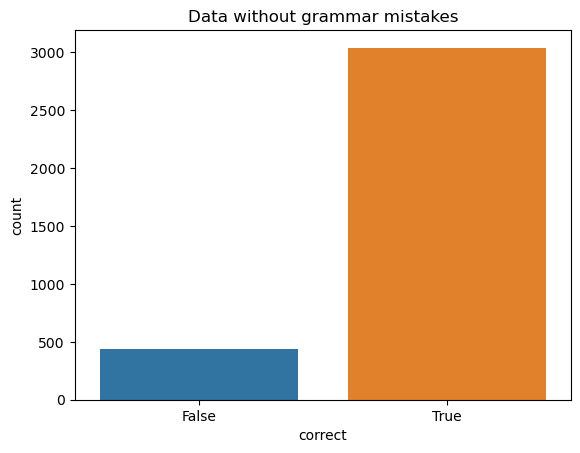

Total wrong data:  438

Percentage: 12.60%


,gendered,neutral,correct
1108,Todos los ponentes al curso recibirá un dossier explicativo,Cada ponente al curso recibirá un dossier explicativo,False
934,los equipos de trabajo funcionan únicamente como vehículo para que alguno pueda hacerse con el control o mantenerse con él,los equipos de trabajo funcionan únicamente como vehículo para que cierta persona pueda hacerse con el control o mantenerse con él,False
965,Todos los ponentes al viaje contará con una acreditación,Cada ponente al viaje contará con una acreditación,False
2192,"Cuyo uso hubiera sido cedido a parientes , incluyendo afines","Cuyo uso hubiera sido cedido a parientes , incluyendo afines",False
857,Todos los asistentes al congreso contará con un dossier explicativo,Cada asistente al congreso contará con un dossier explicativo,False


In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

df_test = df

# add corrected column to original dataframe
df_test['correct'] = results

# plot results
sns.countplot(df_test, x='correct');
plt.title('Data without grammar mistakes')
plt.show()

# Localize non correct
to_correct = df_test[df_test['correct'] == False]
idx_to_correct = to_correct.index
print('Total wrong data: ', to_correct.shape[0])
print(f'\nPercentage: {100*to_correct.shape[0]/df_test.shape[0]:.2f}%')

# print non correct sample
to_correct[['gendered', 'neutral', 'correct']].sample(5)

There is a 12.6% of data with grammar mistakes.

We download the wrong data, correct them manually and reload them.

In [33]:
# Download wrong data
to_correct.to_csv(f'wrong_grammar_data.csv')

# Remove wrong data from dataframe
df_correct = df_test.drop(idx_to_correct, axis='rows')
df_correct = df_correct.drop(columns=['correct'])

After manually correcting data, we load data again and include it to the dataframe.

In [34]:
# Load corrected data
corrected_data = pd.read_csv('corrected_grammar_data.csv')

# Add corrected data to dataframe
df = pd.concat([corrected_data, df_correct], axis='rows')

### 2.4. Repeated text structures detection with Sacrebleu metric

The task now is to detect sentences with similar structures such as: _"Mientras esté ingresado no debe tomar ninguna medicación que no le sea suministrada por los especializados en este caso"_ and _"Mientras esté ingresado no debe tomar agua que no le sea suministrada por los expertos en su cirujía"_. They are very similar sentences which tackle the same difficulty and if sentences in this similar way are repeated excesively they may cause overfitting on the future model. The detection of these structures becomes therefore necessary.

In order to evaluate the similarity between sentences we will use the evaluation metric "Sacrebleu". We will compare all sentence pairs and give them the same structure tag in case they are similar.

In [42]:
import evaluate

# Create column for repetitive structure labeling. Set 'No' by default
df['repetitive_structure'] = 'No'
df = df.reset_index(drop=True)

# import metric
sacrebleu = evaluate.load('sacrebleu')

# set similarity threshold
similarity_threshold = 25

# get ids for rows to compare
mask = df['repetitive_structure'] == 'No'
idx = df[mask].index.to_list()


for row_a in idx:
    first_match = True

    # do not compare sentences with a structure tag
    no_structure_idx = df[df['repetitive_structure'] == 'No'].index.to_list()
    if row_a not in no_structure_idx:
        continue
    
    # compare with sentences different from itself
    structure_tag = f'S{row_a}'
    no_structure_idx.remove(row_a)
    for row_b in no_structure_idx:

        # compute metric between sentences
        similarity_score = sacrebleu.compute(predictions=[df.loc[row_a, 'gendered']], references=[df.loc[row_b, 'gendered']])
        
        # Add tag in case similarity is big enough
        if similarity_score['score'] >= similarity_threshold:
            df.loc[row_b, 'repetitive_structure'] = structure_tag

            # Add tag to initial sentence if it is its first match
            if first_match:
                df.loc[row_a, 'repetitive_structure'] = structure_tag
                first_match = False

Now we count the total number of different structures and identify structures with more than 20 repetitions.

In [44]:
# Get the total number of unique structures
df_structures = df
n_repetitive = df_structures.repetitive_structure.value_counts()
print('Number of unique structures: ', df_structures.repetitive_structure.nunique() + n_repetitive['No'] - 1)

# Get structures with more than 20 repetitions
n_repetitive[n_repetitive > 20]

Number of unique structures:  288


repetitive_structure
S49     465
S30     251
S94     226
S14     168
S293    143
S4      101
S275     89
S261     85
S147     81
S27      80
S11      73
S167     66
No       62
S458     61
S96      57
S540     56
S12      54
S9       53
S7       49
S22      44
S454     32
S46      32
S452     28
S173     25
S98      24
S555     21
S409     21
S531     21
Name: count, dtype: int64

We see that there are many structures with a high number of repetitions.
We will clean repetitions and leave a maximum of 20 repetitions per structure.

In [45]:
str_threshold = 20 # set maximum number of repetitions per structure.

# get structures with more than 20 repetitions
structures = df_structures.repetitive_structure.value_counts()
big_structures = structures[structures > str_threshold].index.to_list()
big_structures.remove('No')

# Remove unwanted repetitions
df_cleaned = df_structures.copy()
for structure in big_structures:
    mask = df_cleaned['repetitive_structure'] == structure
    S_idx = df_cleaned[mask].index
    remove_idx = S_idx[str_threshold:]
    df_cleaned = df_cleaned.drop(remove_idx, axis='rows')

# print results after cleaning
print('Data amount after structure cleaning: ', df_cleaned.shape[0])
df_cleaned.repetitive_structure.value_counts()

Data amount after structure cleaning:  1588


repetitive_structure
No      62
S540    20
S147    20
S94     20
S49     20
        ..
S981     2
S963     2
S459     2
S937     2
S232     2
Name: count, Length: 227, dtype: int64

We have reduced our dataset to less than half, but now we do not have repeated structures and we will have less risk of overfitting.

### 2.5. Text length anomalous distribution

Let us now plot the length distribution after the structure removal and see if the sharp peaks and the annomaly distribution persist.

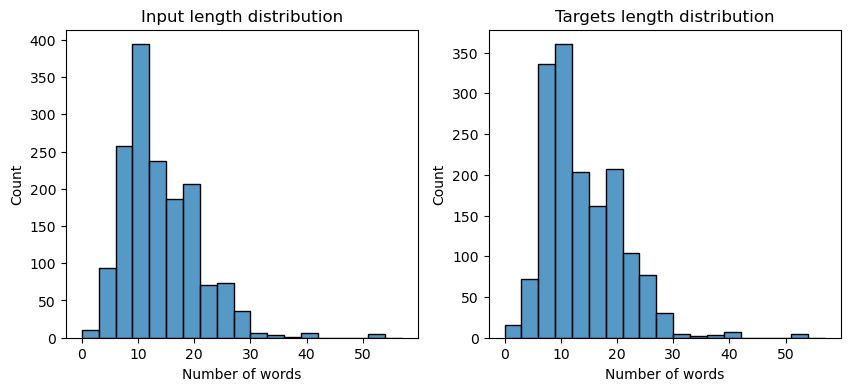

In [46]:
# Count words
inputs_length = df_cleaned['gendered'].map(word_count)
targets_length = df_cleaned['neutral'].map(word_count)

## Plot length distributions
fig, axes = plt.subplots(1,2, figsize=[10,4])

# create histogram bins
bins = np.arange(0, 60, 3)

sns.histplot(inputs_length, ax=axes[0], bins=bins)
axes[0].set_title('Input length distribution')
axes[0].set_xlabel('Number of words')

sns.histplot(targets_length, ax=axes[1], bins=bins)
axes[1].set_title('Targets length distribution')
axes[1].set_xlabel('Number of words');

Sharp peaks have reduced and the distribution is now more normal shaped than before.

If we reduce the maximum number of repetitions per structure we may reduce even more the peaks. In this case we are short of data and we can not afford reducing them more than this.

### 2.6. High number of invariant texts

Now we will see the number of invariant texts after repeated structures removal.

In [48]:
# find and count invariant texts
mask = df_cleaned['gendered'] == df_cleaned['neutral']
n_equals = mask.sum()

# Print results
print('\033[1m Input = Target \033[0m')
print('Total number:', n_equals, 'examples')
print(f'Percentage: {100*n_equals/df.shape[0]:.1f}% of total\n')

 Input = Target 
Total number: 353 examples
Percentage: 10.2% of total



Now we have a more reasonable number of invariant data.

## 3. Save clean data

After fixing all issues we have only left saving the cleaned dataset.

In [51]:
# drop unnecessary columns
df_cleaned = df_cleaned.drop(columns=['repetitive_structure'])

# save clean dataset
df_cleaned.to_csv('es_neutral_cleaned.csv', index=False)